<a href="https://colab.research.google.com/github/malcolmlett/robovac/blob/main/Experiment_SLAM_data_generation_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment: SLAM Data Generation (v1)
This is the first notebook to really seriously look into generating realistic training data for the SLAM model.

This notebook follows on from `Experiment-SLAM-2.ipynb`.

**Focus for this notebook:**
* Generating more realistic LDS data with physically realistic noise.
* Getting agent and map locations more physically realistic.

**Problems identified in Experiment-SLAM-2:**

A number of problems with the data generation were identified there:
* Input maps are too complete and too perfect. They're exactly the same as the ground-truth maps, so there's nothing for the NN to do, and no incentive to use the LDS data to improve the map.
* The NN should always prefer the LDS data over its the input map, as the input map represents only a guess, while LDS is true state. I don't think I've got this balanced quite right in the training data yet.

**Suggestions from Experiment-SLAM-2:**

Some initial ideas for improving the training data were:
* Simulate an agent actually moving around an environment and building up the map from parts, instead of the current extremes: being given either a fully-known map or no-map in between.
  * Imagine taking a path along the map.
  * At each location collect what it can see within the LDS range - this collects a circle of data.
  * Then add some noise the LDS data before turning it into the input map.
  * Later on optionally add motion-skew (where the agent continuously slowly slides slightly to one side so that the SLAM map ends up over a curve and the NN will have to correct that).
  * API note: add collection of options for turning different kinds of errors on/off.
* Play around with occlusions more. Instead of being given a full map for the current location it should be given only a partial map, forcing it to do a partial-match on the map and the LDS data. eg:
  * Randomly drop half of the input map, centred on the map centre, according to a dividing line that goes through the centre at some random angle.
  * Use ~1/3rd sized circles of LDS range and randomly splat them around the map filling in only the parts that are splatted. Do this to build up the input map that is then snapshotted. Take a random number of splats, to simulate different levels of known map. Could be easy to implement by first building up mask from the splats and then applying that against the full map.

In [6]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/robovac.git repo

# lock to revision
#!cd repo && git checkout 49c0dc5
!cd repo && git pull

import sys
sys.path.append('repo')

from general_utils import display_history
import lds
import slam
import slam_data
from importlib import reload
reload(lds)
reload(slam)
reload(slam_data)

HEAD is now at dba3eb3 Locking to revision
Already up to date.


<module 'slam_data' from '/content/repo/slam_data.py'>

In [7]:
!pip install -Uqq ipdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import io
import os
import shutil
import tarfile
import cv2
import requests
import math
import ipdb
import tqdm
import time
from timeit import default_timer as timer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.9 MB/s eta 0:00:00


## LDS sampling with noise

In [12]:
floorplan = Image.open('repo/data/experimental-floorplan2.png')
floorplan = np.array(floorplan, dtype=np.uint8)
print(f"RGB encoded:     shape={floorplan.shape}, dtype={floorplan.dtype}, value range: {np.min(floorplan)} - {np.max(floorplan)}")

floorplan = slam_data.one_hot_encode_floorplan(floorplan).numpy()
print(f"one-hot encoded: shape={floorplan.shape}, dtype={floorplan.dtype}, value range: {np.min(floorplan)} - {np.max(floorplan)}")


RGB encoded:     shape=(139, 294, 3), dtype=uint8, value range: 0 - 255
one-hot encoded: shape=(139, 294, 3), dtype=float32, value range: 0.0 - 1.0


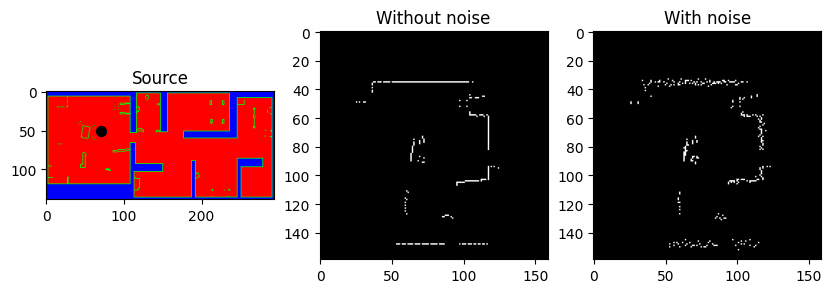

In [5]:
reload(lds)
loc = (70.0, 50.0)
ranges1 = lds.lds_sample(floorplan[:,:,1], np.array(loc) * lds.__PIXEL_SIZE__, angle=0.0, noise_ranges=None)
lds_points1 = lds.lds_to_occupancy_map(ranges1, angle=0.0)

ranges2 = lds.lds_sample(floorplan[:,:,1], np.array(loc) * lds.__PIXEL_SIZE__, angle=0.0)
lds_points2 = lds.lds_to_occupancy_map(ranges2, angle=0.0)

plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.title('Source')
plt.imshow(floorplan)
plt.scatter(loc[0], loc[1], c='k', s=50)

plt.subplot(1,3,2)
plt.title("Without noise")
plt.imshow(lds_points1, cmap='gray')

plt.subplot(1,3,3)
plt.title("With noise")
plt.imshow(lds_points2, cmap='gray')

plt.show()



Generating 5 samples of training data
Pixel size: 44.71
Max distance: 3500
Sample types: [2]


100%|██████████| 5/5 [00:01<00:00,  3.76it/s]


Generated 5 samples after 5 attempts
Dataset tests passed (5 entries verified)
map_window:       (159, 159, 3)
lds_map:          (159, 159)
ground_truth_map: (159, 159, 3)
adlo:             [ 1.          0.04488318 -0.0763452   0.29178823]


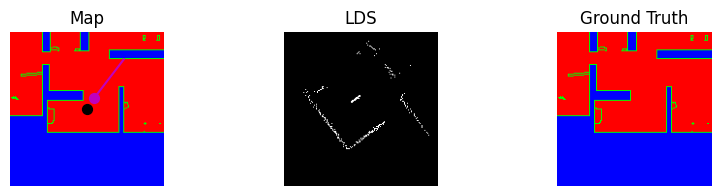

map_window:       (159, 159, 3)
lds_map:          (159, 159)
ground_truth_map: (159, 159, 3)
adlo:             [ 1.          0.3151994  -0.28233716  0.94763739]


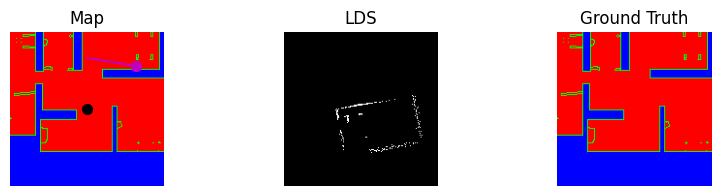

map_window:       (159, 159, 3)
lds_map:          (159, 159)
ground_truth_map: (159, 159, 3)
adlo:             [ 1.         -0.21482507 -0.14407245 -0.37053446]


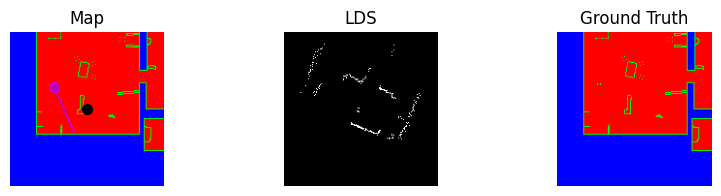

map_window:       (159, 159, 3)
lds_map:          (159, 159)
ground_truth_map: (159, 159, 3)
adlo:             [ 1.         -0.31369648  0.47986412  0.73457215]


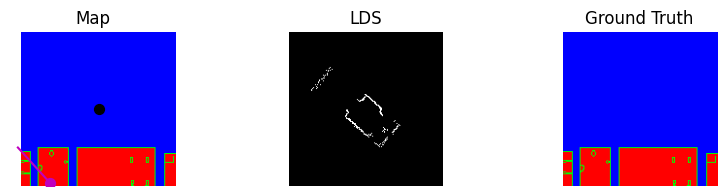

map_window:       (159, 159, 3)
lds_map:          (159, 159)
ground_truth_map: (159, 159, 3)
adlo:             [ 1.         -0.10941691 -0.4066159  -0.55908974]


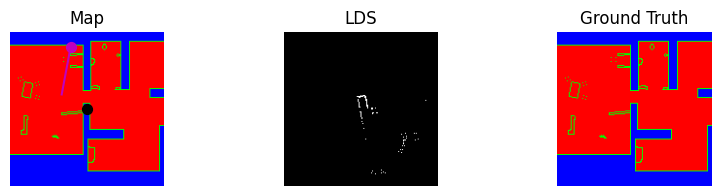

In [12]:
reload(lds)
reload(slam_data)
np.random.seed(0)
dataset = slam_data.generate_training_data(floorplan, 5, sample_types=(2))
slam_data.validate_dataset(dataset)
slam_data.show_dataset(dataset)

## Next Steps

Using model to generate input maps:
* Next step is to start using the model to generate the input map in the training data set.
* Probably split out the training into aeons.
During the first aeon it'll use ground-truth generated input maps.
At the end of each aeon it'll generate new input maps for the dataset and use them in the next aeon.

Improve code:
* The slam_data `generate_training_data_sample` function is a little bit of a mess now. The API I threw together in haste is counter to the way I'm now using it. So that nedes cleaning up.

## Using Model to Generate Map
First, we'll use the model to take a series of snapshots around the floorplan.We'll save them individually, so that we can later dynamically construct model-generated maps of different sections of the floorplan at will.
In other words, in a very crude but time-efficient way, we can simulate the agent taking different paths and having different versions of the map.

In [152]:
!ls

experimental-slam-model3-100epochs.keras  repo
experimental-slam-model3-10epochs.keras   sample_data


In [159]:
## Load an existing model
# (note: the 100epochs file is apparently corrupted)
model = tf.keras.models.load_model('experimental-slam-model3-50epochs.keras')

In [68]:
# conversion from pixel to physical coordinates:
# - a pixel's physical coordinate is at its centre, so the physical coords have range +/- 0.5 of that location
# - a pixel-shape of (2,2) has px coords in range 0..1, if we extend to include the border then we have -0.5..+1.5
def get_location_range(semantic_map, exclude_border=False, **kwargs):
  """
  Centralises the maths to accurately define the range of physical locations across a semantic map.
  Optionally skips the half-pixel width around the edges.
  Both returned low-high have a small margin removed so that it doesn't matter whether subsequent processing treats them as inclusive or exclusive.
  Args:
    semantic_map: entire floorplan or selection
    exclude_border: whether to omit the half-pixel width on the edges.
      Can be used as a very simplistic heuristic to skip the outermost edge that probably has no useful points anyway.
  Returns:
    (low, high) - where low/high are both (x,y) coordinates
  """
  pixel_size = kwargs.get('pixel_size', lds.__PIXEL_SIZE__)
  h, w = np.array(semantic_map.shape[0:2])
  if exclude_border:
    low_px = np.array((0, 0))
    high_px = np.array((w-1, h-1))
  else:
    low_px = np.array((-0.4999, -0.4999))
    high_px = np.array((w-0.5001, h-0.5001))

  return low_px * pixel_size, high_px * pixel_size

range_full = get_location_range(floorplan)
range_reduced = get_location_range(floorplan, exclude_border=True)
print(f"floorplan (px):     {floorplan.shape[1]} x {floorplan.shape[0]}")
print(f"floorplan (mm):     {floorplan.shape[1]*lds.__PIXEL_SIZE__} x {floorplan.shape[0]*lds.__PIXEL_SIZE__}")
print(f"range_full (mm):    {range_full[0]} - {range_full[1]} = {range_full[1] - range_full[0]}")
print(f"range_reduced (mm): {range_reduced[0]} - {range_reduced[1]} = {range_full[1] - range_full[0]}")

floorplan (px):     294 x 139
floorplan (mm):     13144.74 x 6214.6900000000005
range_full (mm):    [-22.350529 -22.350529] - [13122.380529  6192.330529] = [13144.731058  6214.681058]
range_reduced (mm): [0. 0.] - [13100.03  6169.98] = [13144.731058  6214.681058]


map range: [-22.350529 -22.350529] - [13122.380529  6192.330529]
dist: 875.0, w: 13144.74
after filter: locs=(85, 2), orientations: (85,)


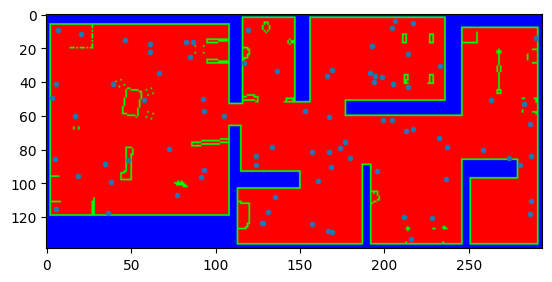

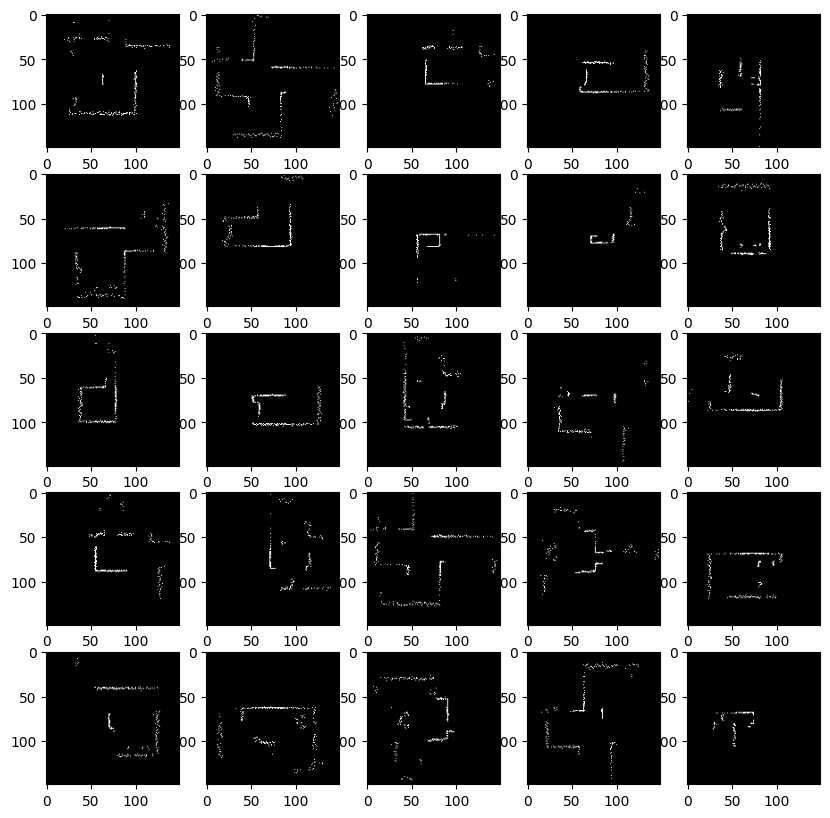

In [142]:
def show_samples(locations, orientations, maps):
  pixel_size = lds.__PIXEL_SIZE__
  plt.imshow(floorplan)
  plt.plot(locs[:,0] / pixel_size, locs[:,1] / pixel_size, '.')
  plt.show()

  plt.figure(figsize=(10,10))
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(maps[i], cmap='gray')
  plt.show()

def take_lds_samples_covering_map(semantic_map, **kwargs):
  """
  Generates a bunch of sample points and LDS maps to cover the area of the given map.
  These can be supplied to the model for map prediction.

  Args:
    semantic_map: entire floorplan or section

  Keyword args:
    pixel_size: the usual
    max_distance: the usual
    resolution: float, default: 0.25.
      Target resolution of sample points, as a fraction of the LDS max distance.
      For example, 0.25 aims to achieve sampling points on a grid with
      0.25*max_distance distance between them.
      In 'random' sampling mode, this is only approximate.
    sampling mode: 'random' or 'grid', default: 'random'.

  Return:
    (locs, orientations, lds_maps)
  """
  # Config
  pixel_size = kwargs.get('pixel_size', lds.__PIXEL_SIZE__)
  max_distance = kwargs.get('max_distance', lds.__MAX_DISTANCE__)
  resolution = kwargs.get('resolution', 0.25)
  sampling_mode = kwargs.get('sampling_mode', 'random')

  # Calculate number of samples to take
  # - if doing a uniform grid with distance d, and ignoring floor vs unknown,
  #   total sample points would be (w/d) * (h/d) = (w*h)/d**2
  # - so use that as the number of points to generate under random sampling mode
  w = semantic_map.shape[1] * pixel_size
  h = semantic_map.shape[0] * pixel_size
  dist = resolution * max_distance
  target_count = math.ceil(w * h / dist**2)
  map_range_low, map_range_high = get_location_range(semantic_map, **kwargs)
  print(f"map range: {map_range_low} - {map_range_high}")
  print(f"dist: {dist}, w: {w}")

  # Generate sample points
  if sampling_mode == 'random':
    locs = np.random.uniform(map_range_low, map_range_high, size=(target_count, 2))
    orientations = np.random.uniform(-np.pi, np.pi, size=(target_count,))
  elif sampling_mode == 'grid':
    x, y = np.meshgrid(np.arange(start=map_range_low[0], stop=map_range_high[0], step=dist),
                       np.arange(start=map_range_low[1], stop=map_range_high[1], step=dist))
    locs = np.stack((x.flatten(), y.flatten()), axis=1)
    orientations = np.zeros(shape=(locs.shape[0],), dtype=np.float32)
  else:
    raise ValueError(f"Unknown sampling_mode: {sampling_mode}")

  # Filter: only include points on the floor
  # - will produce slightly less sample points than target, but it's fine
  mask = np.full(locs.shape[0], True)
  for i in range(locs.shape[0]):
    loc = locs[i]
    mask[i] = slam_data.class_at_location(semantic_map, loc, **kwargs) == slam_data.__FLOOR_IDX__
  locs = locs[mask]
  orientations = orientations[mask]
  print(f"after filter: locs={locs.shape}, orientations: {orientations.shape}")

  # Generate LDS maps
  # - just like in generate_training_data_sample(), we align to map pixels
  #   when rendering
  window_size_px = np.ceil(max_distance / pixel_size).astype(int) * 2 + 1
  window_size_px = np.array([window_size_px, window_size_px])
  locs_fpx = locs / pixel_size  # sub-pixel resolution ("float pixels")
  locs_px = np.round(locs_fpx).astype(int)
  locs_alignment_offset_fpx = locs_fpx - locs_px  # true centre relative to window centre

  ## WORKAROUND:
  # Somehow I'm getting 159x159 windows instead of 149x149 that I've trained the model on.
  # Need to figure out what's going on here.
  def clip_to_size(map):
    target_shape = np.array([149,149])
    clip_start = (map.shape[0:2] - target_shape) // 2
    clip_end = clip_start + target_shape
    return map[clip_start[0]:clip_end[0], clip_start[1]:clip_end[1], ...]

  occupancy_map = semantic_map[..., slam_data.__OBSTRUCTION_IDX__]
  ranges = lds.lds_sample(occupancy_map, locs[0], orientations[0], **kwargs)
  first_map = lds.lds_to_occupancy_map(
      ranges, angle=orientations[0], size_px=window_size_px,
      centre_px=locs_alignment_offset_fpx[0], pixel_size=pixel_size)
  first_map = clip_to_size(first_map)
  lds_maps = np.zeros((locs.shape[0],) + first_map.shape)
  lds_maps[0] = first_map
  for i in range(1, locs.shape[0]):
    ranges = lds.lds_sample(occupancy_map, locs[i], orientations[i], **kwargs)
    lds_map = lds.lds_to_occupancy_map(
        ranges, angle=orientations[i], size_px=window_size_px,
        centre_px=locs_alignment_offset_fpx[i], pixel_size=pixel_size)
    lds_map = clip_to_size(lds_map)
    lds_maps[i] = lds_map

  return locs, orientations, lds_maps


np.random.seed(0)
locs, orientations, lds_maps = take_lds_samples_covering_map(floorplan, sampling_mode='random')
show_samples(locs, orientations, lds_maps)

In [160]:
def show_semantic_samples(locations, orientations, semantic_maps):
  pixel_size = lds.__PIXEL_SIZE__
  plt.imshow(floorplan)
  plt.plot(locs[:,0] / pixel_size, locs[:,1] / pixel_size, '.')
  plt.show()

  plt.figure(figsize=(10,10))
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(semantic_maps[i])
    plt.axis('off')
  plt.show()

def predict_maps(model, locs, orientations, lds_maps, **kwargs):
  """
  Uses the model to predict the semantic maps.
  Return:
    (locs, orientations, semantic_maps) with predicted maps
  """
  unknown_value = np.zeros(slam_data.__CLASSES__, dtype=np.float32)
  unknown_value[slam_data.__UNKNOWN_IDX__] = 1

  unknown_maps = np.tile(unknown_value, tuple(lds_maps.shape) + (1,))

  print(f"locs: {locs.shape}")
  print(f"orientations: {orientations.shape}")
  print(f"unknown_maps: {unknown_maps.shape}")
  print(f"lds_maps: {lds_maps.shape}")

  (semantic_maps, adlos) = model.predict((unknown_maps, lds_maps))
  semantic_maps = tf.math.softmax(semantic_maps, axis=-1)

  print(f"semantic_maps: {semantic_maps.shape}")
  print(f"adlos: {adlos.shape}")
  return locs, orientations, semantic_maps

(locs2, orientations2, semantic_maps2) = predict_maps(model, locs[0:25], orientations[0:25], lds_maps[0:25])
show_semantic_samples(locs2, orientations2, semantic_maps2)

locs: (25, 2)
orientations: (25,)
unknown_maps: (25, 149, 149, 3)
lds_maps: (25, 149, 149)
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
semantic_maps: (25, 149, 149, 3)
adlos: (25, 4)


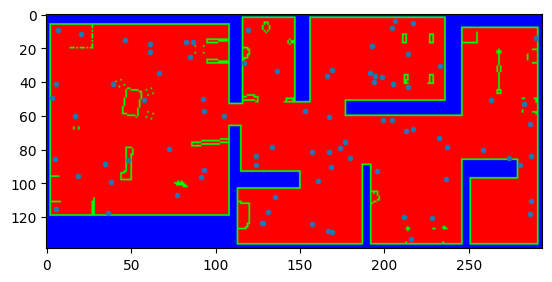

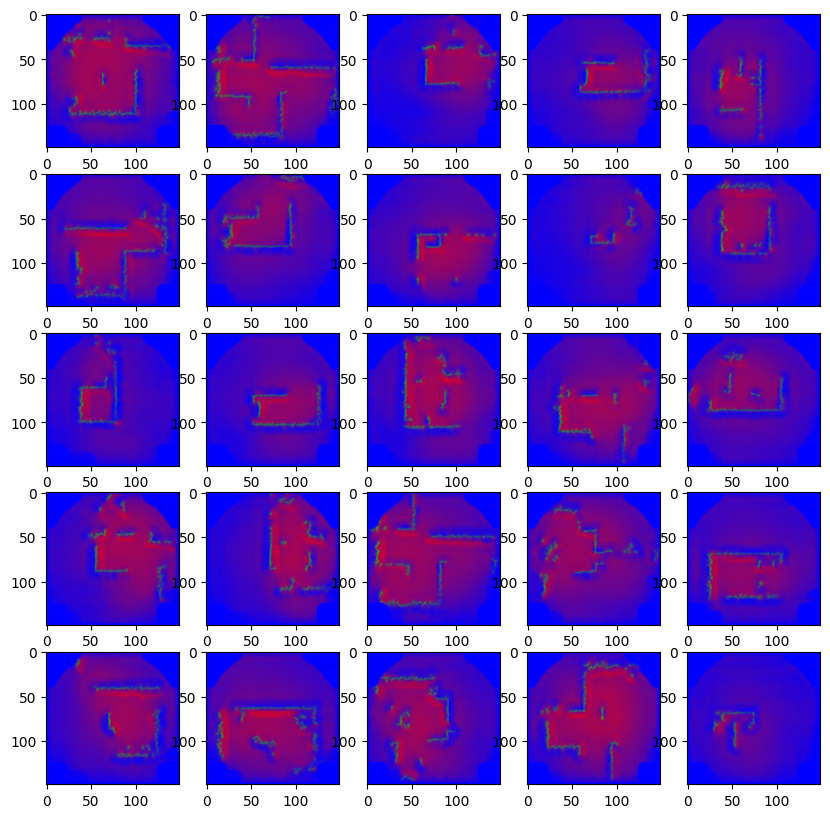

In [161]:
show_semantic_samples(locs2, orientations2, semantic_maps2)

In [14]:
139*294 / (19.6**2)

106.37755102040813

In [16]:
139*294 / (78.3**2)

6.665590150859011

In [17]:
79*2+1

159

In [18]:
159*159 / (78.3**2)

4.123544868689538

In [19]:
159/78


2.0384615384615383

In [25]:
h,w = floorplan.shape[0:2]
d = 3500*0.25/lds.__PIXEL_SIZE__
print(f"floorplan shape (px): {w} x {h}")
print(f"target distance (px): {d}")
print(f"uniform grid counts: {w/d} x {h/d} = {(w/d) * (h/d)}")

floorplan shape (px): 294 x 139
target distance (px): 19.570565868933123
uniform grid counts: 15.02256 x 7.1025028571428575 = 106.6977753216
